In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group

from database import YaleStarCatalog, StarCatalog, InterAngleCatalog
# from matching.subgraph import matching_set_for_analysis
from utils.unit_convert import deg2rad
from utils.seeds import gen_seeds
from utils.spherical_ramdom_vector import limit_uniform_spherical_vector
from utils.rotation import rodrigues_rotation_matrix
from utils.font import font_setting


font_setting()

DPI = 100
FIG_SIZE = (12, 7)

In [2]:
### Parameter ###
# sys
log_dir = './log/'
# config
seed = 100
roopN = 1000
U = 4096
limitMv = 5.5

FOV_deg = 5
FOV = deg2rad(FOV_deg)
obsMv = 5.5
cover_alpha = 0.4

sigma = np.arctan2(2*np.tan(FOV*0.5), U)
epsilon = 2*sigma

In [3]:
def equatorial2vec(alpha, delta):
    rets = np.empty((len(alpha), 3))
    rets[:, 0] = np.cos(alpha) * np.cos(delta)
    rets[:, 1] = np.sin(alpha) * np.cos(delta)
    rets[:, 2] = np.sin(delta)
    return rets

def rotate(R, vec):
    ret = np.empty((R.shape[0], vec.shape[0], vec.shape[1]))
    for i in range(R.shape[0]):
        ret[i, :, :] = np.dot(R[i], vec.T).T
    return ret

def rotate_(R, vec):
    ret = np.empty((vec.shape[0], vec.shape[1]))
    for i in range(R.shape[0]):
        ret[i, :] = np.dot(R[i], vec[i].T).T
    return ret

----- Yale Bright Star Catalog -----
the number of stars : 9096
the range of magnitude : [-1.46, 7.96]


Text(0, 0.5, 'Declination')

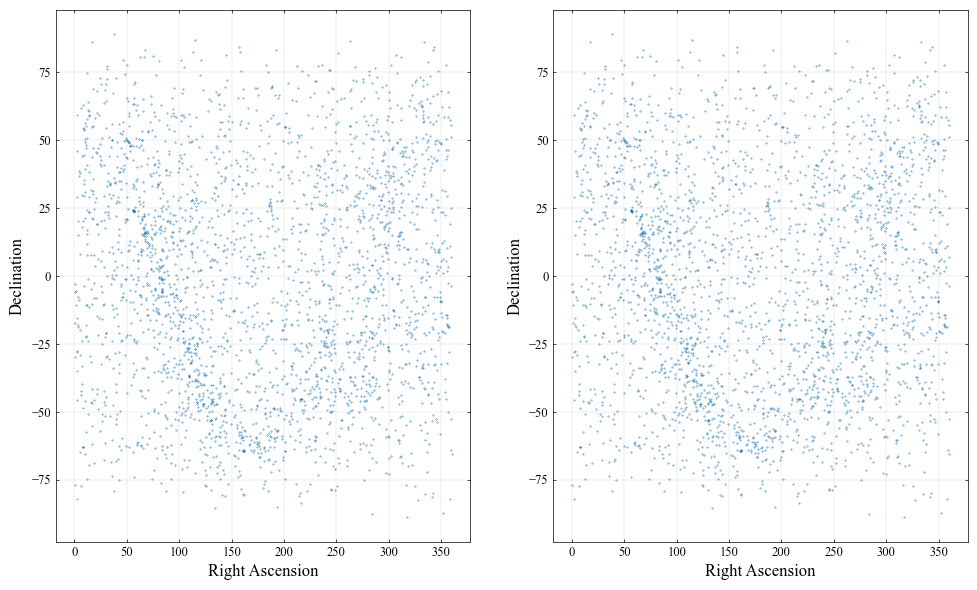

In [4]:
### Catalog setup ###
yale = YaleStarCatalog(log_dir=log_dir)
star_ctlg = StarCatalog(yale.get_HR(), yale.get_RA(), yale.get_DE())
star_ctlg.filtering_by_visual_magnitude(yale.get_Vmag(), limitMv)
star_ctlg.filtering_by_multiple_stars(epsilon)

### MONTE CARLO SIMULATION ###
# observe catalog
obs_star_ctlg = StarCatalog(yale.get_HR(), yale.get_RA(), yale.get_DE())
obs_star_ctlg.filtering_by_visual_magnitude(yale.get_Vmag(), limitMv)
obs_star_ctlg.filtering_by_multiple_stars(epsilon)    
obs_star_ctlg.filtering_by_visual_magnitude(yale.get_Vmag(), obsMv)
s_vec = equatorial2vec(obs_star_ctlg.get_RA(), obs_star_ctlg.get_DE())
N_catalog = len(s_vec)

# plot 
fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
ax = fig.add_subplot(121)
ax.scatter(star_ctlg.get_RA()*180/np.pi, star_ctlg.get_DE()*180/np.pi, s=0.1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ax = fig.add_subplot(122)
ax.scatter(obs_star_ctlg.get_RA()*180/np.pi, obs_star_ctlg.get_DE()*180/np.pi, s=0.1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')



100%|██████████| 9346/9346 [00:06<00:00, 1480.20it/s]


Text(0, 0.5, 'Declination')

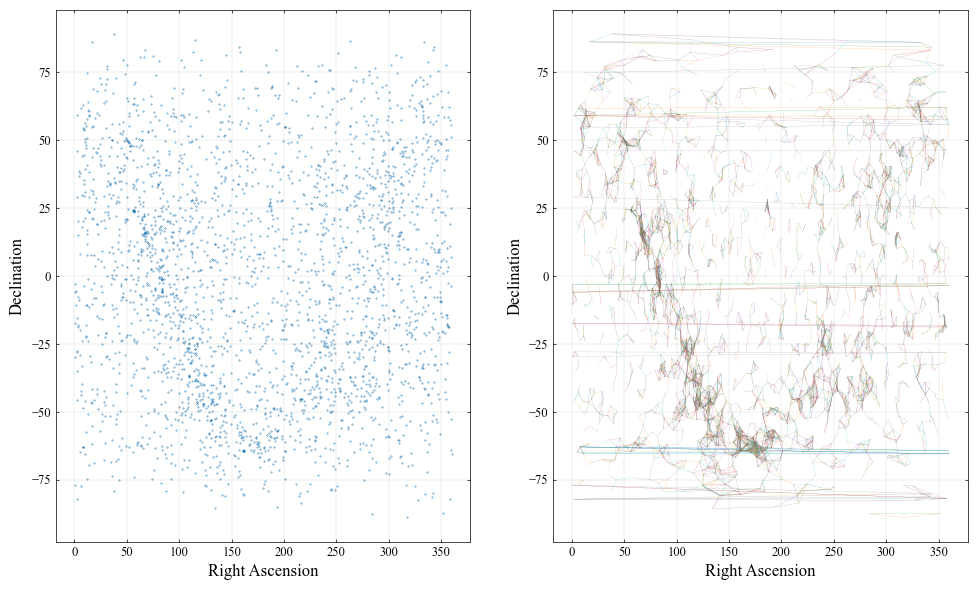

In [5]:
angle_ctlg = InterAngleCatalog(
    star_ctlg.get_ID(), star_ctlg.get_RA(), star_ctlg.get_DE(),
    log_dir=log_dir)
angle_ctlg.create_catalog(FOV=FOV, use_log=False)

pair_ids = angle_ctlg.get_pair_index()
s_vec = equatorial2vec(star_ctlg.get_RA(), star_ctlg.get_DE())

fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
ax = fig.add_subplot(121)
ax.scatter(star_ctlg.get_RA()*180/np.pi, star_ctlg.get_DE()*180/np.pi, s=0.1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ax = fig.add_subplot(122)
for pair_id in tqdm.tqdm(pair_ids):
    ax.plot(
        [star_ctlg.get_RA()[pair_id[0]]*180/np.pi, star_ctlg.get_RA()[pair_id[1]]*180/np.pi],
        [star_ctlg.get_DE()[pair_id[0]]*180/np.pi, star_ctlg.get_DE()[pair_id[1]]*180/np.pi],
        lw=0.1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

In [6]:
from utils.inter_star_angle import inter_star_angle_RADE

inter_angles = inter_star_angle_RADE(
    star_ctlg.get_RA()[pair_ids[:, 0]], star_ctlg.get_DE()[pair_ids[:, 0]],
    star_ctlg.get_RA()[pair_ids[:, 1]], star_ctlg.get_DE()[pair_ids[:, 1]])

print(np.max(np.abs(angle_ctlg.get_inter_angles() - inter_angles)))


0.0


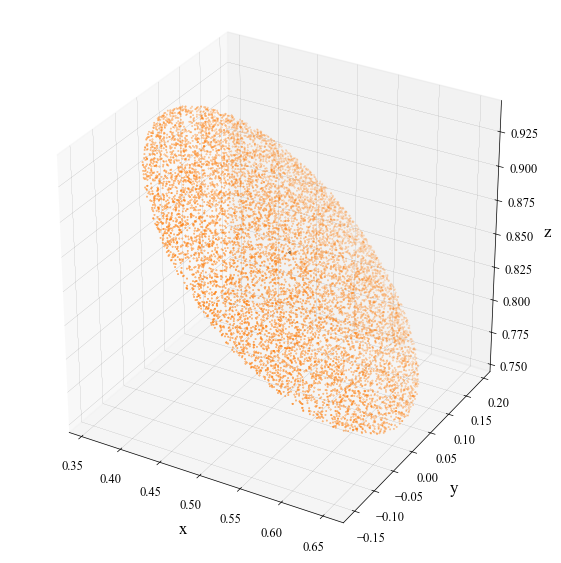

In [21]:
obs_ID = obs_star_ctlg.get_ID()[[2]*10000]
obs_RA = obs_star_ctlg.get_RA()[[2]*10000]
obs_DE = obs_star_ctlg.get_DE()[[2]*10000]
s_vec = equatorial2vec(obs_RA, obs_DE)

obs_noise = limit_uniform_spherical_vector(
    sigma=10*np.pi/180, n=len(obs_ID), seed=100)
axis_vec = np.concatenate(
    [np.cos(obs_RA+0.5*np.pi)[:, np.newaxis],
    np.sin(obs_RA+0.5*np.pi)[:, np.newaxis],
    np.zeros_like(obs_ID)[:, np.newaxis]],
    axis=1) 
R_s_vec = rodrigues_rotation_matrix(0.5*np.pi-obs_DE, axis_vec)
obs_s_vec = rotate_(R_s_vec, obs_noise)

fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(s_vec[:, 0], s_vec[:, 1], s_vec[:, 2], s=0.1)
ax.scatter(obs_s_vec[:, 0], obs_s_vec[:, 1], obs_s_vec[:, 2], s=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_zlim(-1, 1)
ax.set_box_aspect((1,1,1))